In [34]:
#
# UMAP
#

import numpy as np

x = np.fromfile('../data/mnist/t10k-images-idx3-ubyte', np.uint8, offset=16)
y = np.fromfile('../data/mnist/t10k-labels-idx1-ubyte', np.uint8, offset=8)

x = x.reshape((-1, 28 * 28))
x = x.astype(np.float32) / 255

assert x.shape == (10000, 28 * 28)
assert y.shape == (10000,) 

In [43]:
import umap

umap_instance = umap.UMAP()
umap_instance.verbose = True
umap_instance.init = 'random'
umap_instance.n_epochs = 200

In [44]:
umap_instance.fit(x)

UMAP(init='random', n_epochs=200, verbose=True)
Construct fuzzy simplicial set
Thu Jul  9 10:40:01 2020 Finding Nearest Neighbors
Thu Jul  9 10:40:01 2020 Building RP forest with 10 trees
Thu Jul  9 10:40:01 2020 NN descent for 13 iterations
	 0  /  13
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	 6  /  13
	 7  /  13
Thu Jul  9 10:40:04 2020 Finished Nearest Neighbor Search
Thu Jul  9 10:40:05 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Thu Jul  9 10:40:10 2020 Finished embedding


UMAP(init='random', n_epochs=200, verbose=True)

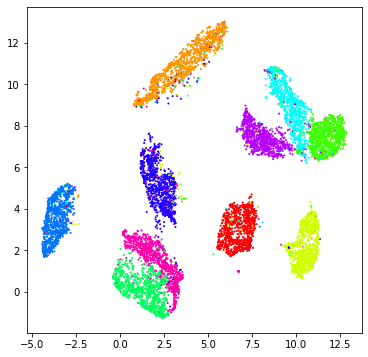

In [46]:
import matplotlib.pyplot as plt

e = umap_instance.embedding_
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(e[:, 0], e[:, 1], c=y/10, s=1, cmap='hsv', vmin=0, vmax=1)

In [1]:
#
# Numba/Python multithreading
#

import numpy as np
import numba

def f1(x, y, z):
    n = x.shape[0]
    for i in numba.prange(n):
        z[i] = x[i] + y[i]

def f2(x, y, z):
    z[:] = x + y
    
f3 = numba.njit(["void(float32[:], float32[:], float32[:])"], parallel=False, nogil=True)(f1)
f4 = numba.njit(["void(float32[:], float32[:], float32[:])"], parallel=True, nogil=True)(f1)

In [2]:
numba.threading_layer(), numba.get_num_threads()

('tbb', 4)

In [3]:
n = 2**25
x = np.arange(n, dtype=np.float32)
z = np.empty_like(x)

f3(x, x, z)
f4(x, x, z)

In [4]:
%timeit -n 10 -r 2 f3(x, x, z)

29.3 ms ± 1.51 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)


In [12]:
%timeit -n 10 -r 2 f4(x, x, z)

27.4 ms ± 1.17 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)


In [6]:
import concurrent.futures

def make_chunks(n, num_chunks):
    chunk_size = n // num_chunks
    chunks = [[i * chunk_size, (i + 1) * chunk_size] for i in range(num_chunks)]    
    return chunks

k = 4
executer = concurrent.futures.ThreadPoolExecutor(max_workers=k)
chunks = make_chunks(n, k)

def run_chunk(se):
    s, e = se
    f3(x[s:e], x[s:e], z[s:e])
    
list(executer.map(run_chunk, chunks))

[None, None, None, None]

In [8]:
import threading

def run_threads():
    threads = []
    for [s, e] in chunks:
        t = threading.Thread(target=f3, args=(x[s:e], x[s:e], z[s:e]))
        threads.append(t)

    for t in threads:
        t.start()
        
    for t in threads:
        t.join()
        
run_threads()        

In [13]:
%timeit -n 10 -r 2 list(executer.map(run_chunk, chunks))

26.8 ms ± 936 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)


In [11]:
%timeit -n 10 -r 2 run_threads()

24.5 ms ± 833 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
